In [58]:
# import the libraries

# Data preprocessing
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (29, 10)
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline


# Distribution of histograms
from scipy import stats
from scipy.stats import norm

# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeRegressor

# Dimensionality reduction
from sklearn.decomposition import PCA

# Evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score


from sklearn.model_selection import cross_val_score, train_test_split

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from time import time
import visuals as vs

from IPython.display import display

from sklearn.base import clone
from simple_colors import *

In [59]:
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Channel', 'Region'], axis=1, inplace=True)
    print("Wholesale customer dataset has {} samples and {} features each.".format(*data.shape))
except:
    print("Data was not loaded. Is the dataset missing?")

Wholesale customer dataset has 440 samples and 6 features each.


**Data Exploration**

In [60]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicatessen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [187]:
# Choose three indices that you further study in more detail
indices = [22, 222, 333]

samples = pd.DataFrame(data.loc[indices], columns=data.keys())
print("Chosen samples of wholesale dataset.")
display(samples)

Chosen samples of wholesale dataset.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
22,31276,1917,4469,9408,2381,4334
222,5041,1115,2856,7496,256,375
333,8565,4980,67298,131,38102,1215


##### **Question 1**
What kind of estabilishment do you think data three data samples represent?
- **Index 10**: Fresh amount of products are above 25%. Below average is Milk. Grocery and Detergents_Paper uses are extremely high above 75%. Frozen is below average. Lastly Delicatesessen is above average. **This could be a restaurant**
- **Index 100**: The amount of Fresh products are in demand with more than 50%; above average. Milk, Grocery, Detergents_Paper, and Delicatesessen uses are very high at more than 75% in demand. Frozen products are also above average signifying that this could be **market or a retail business**.
- **Index 200**: This customer has almost all categories in larges amounts as Index 100. This could mean that it is a **retail store or a market**



**Feature relevance**

In [188]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.copy().drop('Frozen', axis=1).values

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(
    new_data, data.Frozen.values, test_size=0.20, random_state=42
)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

# TODO: Report the score of the prediction using the testing set
score = r2_score(y_test, predictions)
score

-0.37258149328793433

#### **Question 2**
- Which feature did you attempt to predict? **Frozen**
- What was the reported prediction score? **r2_score -> -0.43340745969671857**
- Is this feature necessary for identifying customers' spending habits? **No**
<hr>
- Features that have an effect on customers' spending habits:
    - Detergents_Paper
    - Grocery
    - Milk


**Visualize Feature Distributions**

<function matplotlib.pyplot.show(close=None, block=None)>

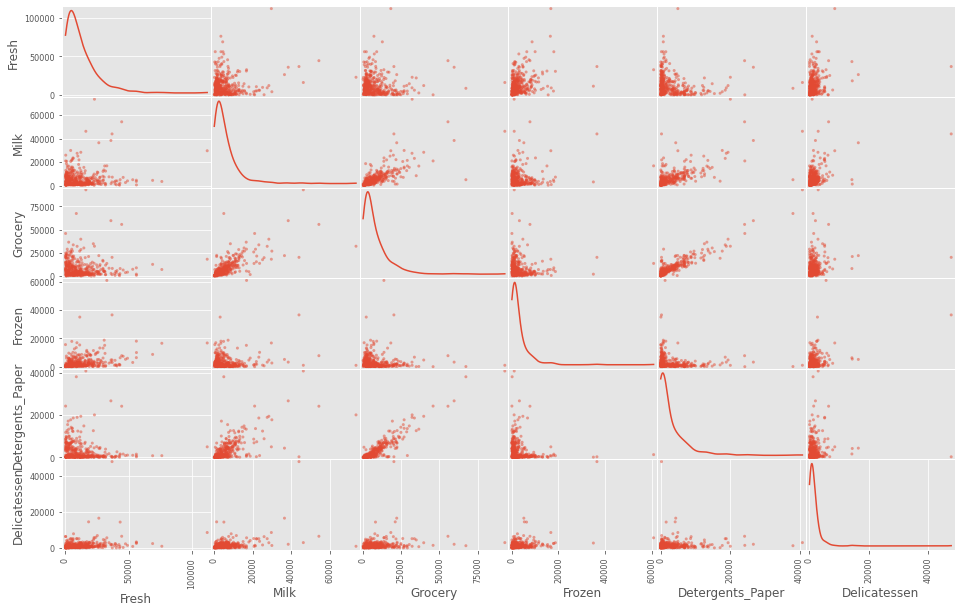

In [189]:
pd.plotting.scatter_matrix(data, diagonal='kde', figsize=(16,10))
plt.show

<AxesSubplot:>

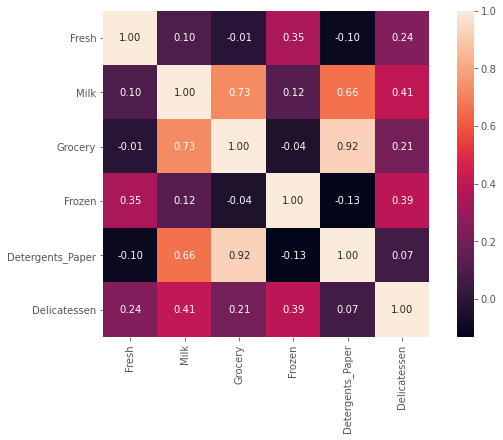

In [190]:
plt.figure(figsize=(10, 6))
corrmat = data.corr()
sns.heatmap(corrmat, annot=True, square=True, fmt='.2f')

Just as observed earlier, above heatmap shows that `Detergets_Paper`, `Grocery` and `Milk` are highly correlated, while `Frozen`, and `Fresh` have low correlation. `Delicatessen` has correlations with some variables bt not as high as its counterparts.

**Data Preprocessing**
- Feature scaling using natural logarithm
- Removing outliers

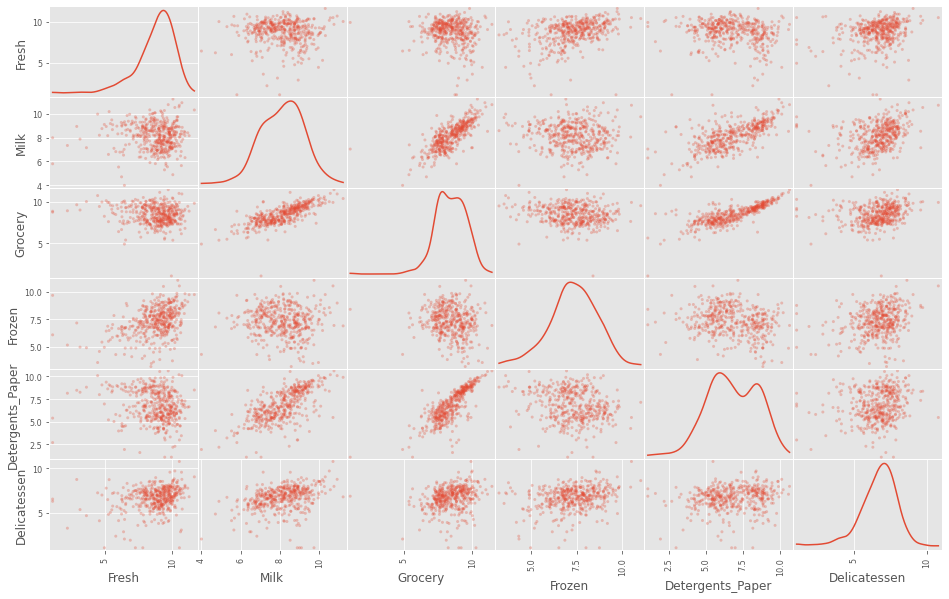

In [191]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

** Observation **
<hr>
Before applying feature scaling with natural lograithm, the previous scatter matrix revealed that data was positively skewed(on the right) indicating that there wasn't a normal distribution. After applying natural logarithm to our dataset, we see that it is now evenly and normally distributed, and that the variables maintain their correlations.

**Outlier Detection**

In [192]:
from collections import Counter


def outliers(column):
    Q1, Q3 = np.percentile(column, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range


allOutliers = []
for feature in log_data.keys():
    lower_range = outliers(log_data[feature])[0]
    upper_range = outliers(log_data[feature])[1]
    
    
    print("\nIndices with outliers for the feature '{}'\n------".format(feature))
    indices = log_data[~((log_data[feature] >= lower_range) & (log_data[feature] <= upper_range))].index
    
    # Display the indices
    
    print(indices)
    for index in indices: allOutliers.append(index)
    
    print("\nNumber of outliers in '{}'\n------\n{}".format(feature, len(log_data.iloc[indices])))
    
    # Display the indices
    display(log_data.iloc[indices])
    print('*'*100)
    

count = Counter(allOutliers)
repeating = Counter(el for el in count.elements() if count[el] > 1)
print('The total number of repeating outliers\n------\n {}'.format(len(repeating)))

print('\n Repeating indexes\n------\n {}'.format(repeating.keys()))

# remove the outliers
good_data = log_data.drop(log_data.iloc[allOutliers].index, axis=0).reset_index(drop=True)


Indices with outliers for the feature 'Fresh'
------
Int64Index([65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355,
            357, 412],
           dtype='int64')

Number of outliers in 'Fresh'
------
16


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


****************************************************************************************************

Indices with outliers for the feature 'Milk'
------
Int64Index([86, 98, 154, 356], dtype='int64')

Number of outliers in 'Milk'
------
4


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


****************************************************************************************************

Indices with outliers for the feature 'Grocery'
------
Int64Index([75, 154], dtype='int64')

Number of outliers in 'Grocery'
------
2


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


****************************************************************************************************

Indices with outliers for the feature 'Frozen'
------
Int64Index([38, 57, 65, 145, 175, 264, 325, 420, 429, 439], dtype='int64')

Number of outliers in 'Frozen'
------
10


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


****************************************************************************************************

Indices with outliers for the feature 'Detergents_Paper'
------
Int64Index([75, 161], dtype='int64')

Number of outliers in 'Detergents_Paper'
------
2


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


****************************************************************************************************

Indices with outliers for the feature 'Delicatessen'
------
Int64Index([66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289,
            343],
           dtype='int64')

Number of outliers in 'Delicatessen'
------
14


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


****************************************************************************************************
The total number of repeating outliers
------
 5

 Repeating indexes
------
 dict_keys([65, 66, 128, 154, 75])


**Feature Transformation**
- Using PCA to find dimensions with maximum variance; compound combinations of features which best describe customers.

The first two have a variance of 0.7253


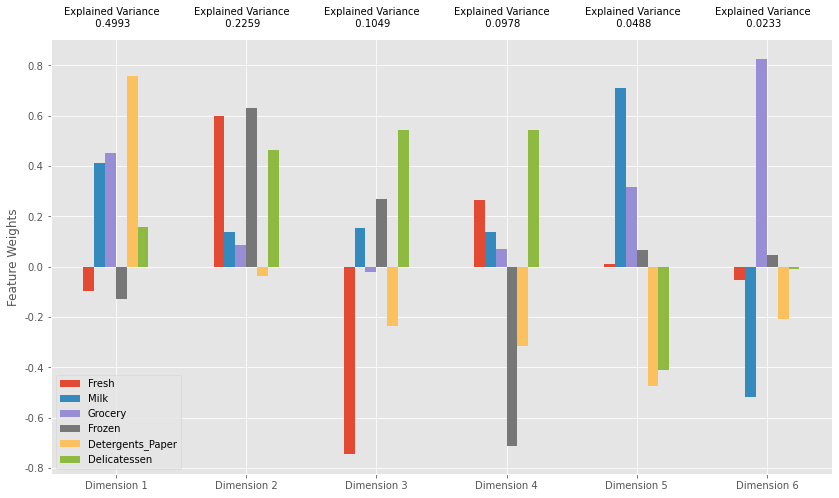

In [193]:
import visuals as vs
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

# Explained Variance Ratio
first_two = pca.explained_variance_ratio_[[0, 1]].sum()
print('The first two have a variance of {:.4f}'.format(first_two))

In [194]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,0.4026,2.5486,-0.0626,-0.3826,-1.3865,0.0638
1,-1.8949,0.1462,0.3592,-1.4422,0.1146,0.5495
2,4.5971,-1.2540,-1.4870,1.0766,-0.9400,1.1157


**Dimensionality Reduction with n_components=2**

In [195]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [196]:
reduced_data

,Dimension 1,Dimension 2
0,1.779322,-0.660449
1,1.882034,0.461741
2,1.993507,1.247080
3,-0.998581,1.369364
4,0.993847,2.078314
...,...,...
393,1.092404,-0.088703
394,-0.363319,2.871768
395,-3.002061,1.868559
396,3.848267,0.144421


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

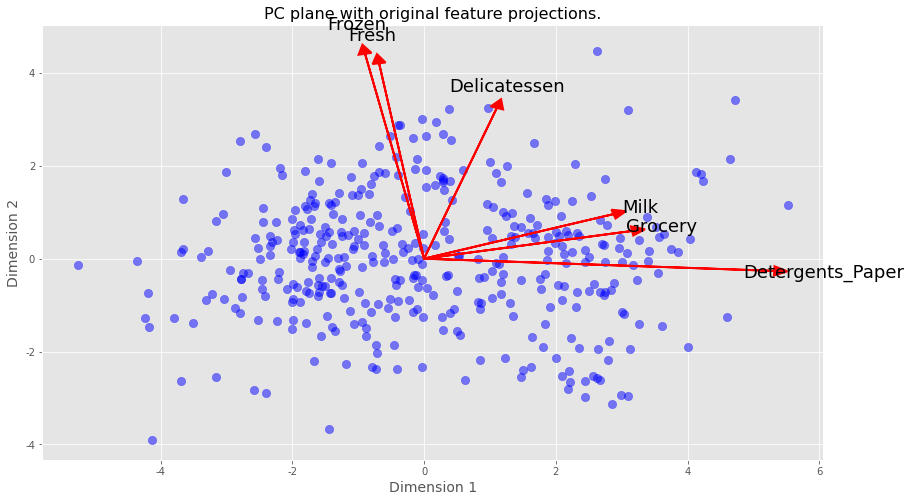

In [197]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

**Creating Clusters**

Text(0, 0.5, 'WCSS')

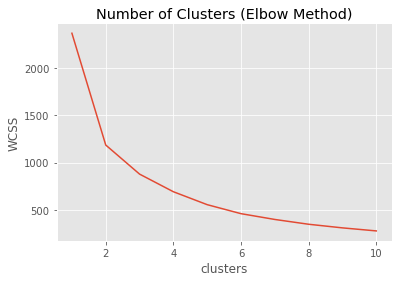

In [198]:
wcss = []
for i in range(1, 11):
    kmeans =  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Number of Clusters (Elbow Method)')
plt.xlabel('clusters')
plt.ylabel('WCSS')

In [199]:
# fit K-Means with 2 clusters
clusterer = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)

preds = clusterer.fit_predict(reduced_data)
sample_preds = clusterer.predict(pca_samples)

# silhouette score
score = silhouette_score(reduced_data, preds)
print("Silhouette_score: {:.4f}".format(score))

Silhouette_score: 0.4472


<function matplotlib.pyplot.show(close=None, block=None)>

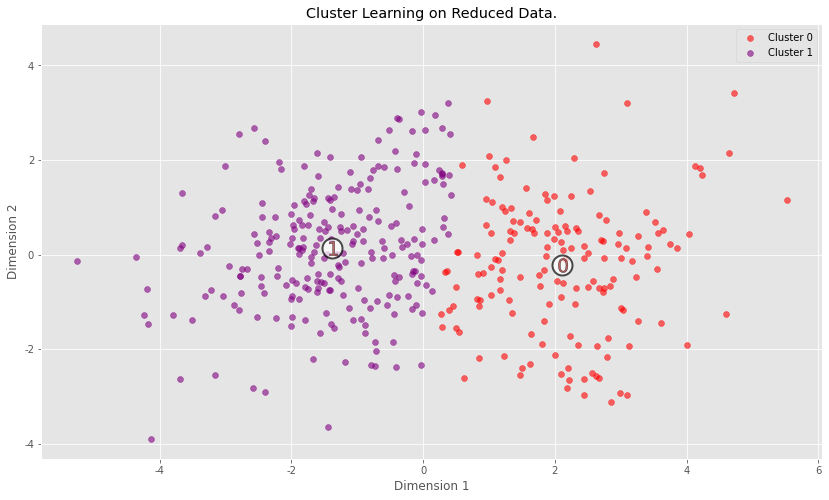

In [210]:
plt.figure(figsize=(14, 8))
plt.scatter(reduced_data.values[preds == 0, 0], reduced_data.values[preds == 0, 1], alpha=0.6, color='red', label='Cluster 0')
plt.scatter(reduced_data.values[preds == 1, 0], reduced_data.values[preds == 1, 1], alpha=0.6, color='purple', label='Cluster 1')
for i, centroid in enumerate(clusterer.cluster_centers_):
    plt.scatter(centroid[0], centroid[1], s=400, color='white', edgecolors='black', linewidths=2, alpha=0.7, marker='o')
    plt.scatter(centroid[0], centroid[1], s=200, color='brown', edgecolors='black', alpha=0.7, marker='$%d$'%(i))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cluster Learning on Reduced Data.')
plt.legend()
plt.show

**Data Recovery**

In [201]:
# TODO: Inverse transform the centers
centers = clusterer.cluster_centers_
log_centers = pca.inverse_transform(reduced_data)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4286.0,6386.0,9557.0,885.0,3511.0,877.0
1,8326.0,7768.0,11015.0,1771.0,3639.0,1499.0
2,13202.0,9055.0,12384.0,2863.0,3846.0,2195.0
3,19026.0,2693.0,3245.0,4536.0,394.0,1448.0
4,23982.0,6730.0,8467.0,5493.0,1744.0,2755.0
...,...,...,...,...,...,...
393,6461.0,5208.0,7361.0,1385.0,2040.0,1025.0
394,44099.0,4296.0,4911.0,10773.0,604.0,3212.0
395,31225.0,1266.0,1371.0,8028.0,85.0,1330.0
396,5680.0,16682.0,26029.0,1127.0,16398.0,1764.0


In [203]:
# Display the predictions of the sample data
display(data.describe())
display(samples)
for i, (pred, sample) in enumerate(zip(sample_preds, samples.values)):
    print("Sample point", i, "predicted to be in Cluster", pred)
    print("Data for this sample\n------\n{}\n".format(sample))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
22,31276,1917,4469,9408,2381,4334
222,5041,1115,2856,7496,256,375
333,8565,4980,67298,131,38102,1215


Sample point 0 predicted to be in Cluster 1
Data for this sample
------
[31276  1917  4469  9408  2381  4334]

Sample point 1 predicted to be in Cluster 1
Data for this sample
------
[5041 1115 2856 7496  256  375]

Sample point 2 predicted to be in Cluster 0
Data for this sample
------
[ 8565  4980 67298   131 38102  1215]



In [220]:
good_data['Cluster'] = clusterer.predict(reduced_data)
display(good_data.head(20))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Cluster
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,0
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,0
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,0
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,1
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,0
5,9.149847,9.019059,8.542081,6.501290,7.492760,7.280008,0
6,9.403107,8.070594,8.850088,6.173786,8.051978,6.300786,0
7,8.933137,8.508354,9.151227,7.419980,8.108021,7.850104,0
8,8.693329,8.201934,8.731013,6.052089,7.447751,6.620073,0
9,8.700514,9.314070,9.845911,7.055313,8.912608,7.648740,0
